# Промышленность. Определение температуры стали

Для оптимизации производственных расходов построена эмпирическая модель (LightGBM), предсказывающая конечную температуру стали в плавильном ковше. Модель учитывает не только мощность, подаваемую в расплав, но и тип и объем примесей, продув инертным газом и проч. Так же произведен подробный анализ значимости признаков, позволивший упростить модель, но сохранить ее высокое качество

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Оглавление

* [Первичный анализ](#1)
* [Исследовательский анализ данных](#2)
    * [Временной интервал на одну партию](#2.1)
    * [Схема обработки стали для первой партии](#2.2)
* [Предварительные выводы и план работы](#3)
* [Агрегация данных](#4)
* [Работа с аномалиями](#5)
* [Подготовка данных к обучению](#6)
* [Линейная регрессия](#7)
* [Исследование значимости признаков c помощью линейно регрессии](#8)
* [Случайный лес](#9)
* [Исследование значимости признаков с помощью случайного леса](#10)
* [LightGBM](#11)
* [Обучение модели-лидера на значимых призаках](#12)
* [Общий вывод](#13)

<a id='1'></a>
## Первичный анализ

In [1]:
import seaborn as sns
sns.set_theme()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
df_arc = pd.read_csv('final_steel/data_arc.csv', parse_dates = [1, 2], index_col = [0])
df_bulk = pd.read_csv('final_steel/data_bulk.csv', index_col = [0])
df_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv', parse_dates = [i for i in range(1,16)], index_col = [0])
df_gas  = pd.read_csv('final_steel/data_gas.csv', index_col = [0])
df_temp = pd.read_csv('final_steel/data_temp.csv', parse_dates = [1], index_col = [0])
df_wire = pd.read_csv('final_steel/data_wire.csv', index_col = [0])
df_wire_time = pd.read_csv('final_steel/data_wire_time.csv', parse_dates = [i for i in range(1,10)], index_col = [0])

In [6]:
data = [df_arc, df_bulk, df_bulk_time, df_gas, df_temp, df_wire, df_wire_time]

In [7]:
for df in data:
    df.head()

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


,Время замера,Температура
key,,
1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:25:53,1604.0
1,2019-05-03 11:29:11,1618.0
1,2019-05-03 11:30:01,1601.0
1,2019-05-03 11:30:39,1613.0


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [8]:
for df in data:
    print('')
    df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14876 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Начало нагрева дугой  14876 non-null  datetime64[ns]
 1   Конец нагрева дугой   14876 non-null  datetime64[ns]
 2   Активная мощность     14876 non-null  float64       
 3   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 581.1 KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     float64
 5   Bulk 6   576 non-null    float64
 6   Bulk 7   25 non-null     float64
 7   Bulk 8   1 non-null      flo

__Промежуточный вывод__

Данные приведены к корректным типам и по-видимому требуют только агрегациию. Пропуски скорее всего означют, что данный компонент просто не добавлялся к расплаву, поэтому пропуски не требуют предварительного заполнения

<a id='2'></a>
## Исследовательский анализ данных
<a id='2.1'></a>
### Временной интервал на одну партию

In [9]:
df_arc[df_arc.index == 1]['Конец нагрева дугой'].min()

Timestamp('2019-05-03 11:06:02')

In [10]:
df_arc[df_arc.index  == 1]['Конец нагрева дугой'].max()

Timestamp('2019-05-03 11:28:37')

In [11]:
times = []
for key in df_arc.index.unique():
    t = df_arc[df_arc.index  == key]['Конец нагрева дугой'].max() - df_arc[df_arc.index  == key]['Начало нагрева дугой'].min()
    times.append(t.total_seconds()/60)

In [12]:
times = pd.Series(times)

<AxesSubplot:>

Text(0.5, 1.0, 'duration distribution')

Text(0.5, 0, 'duration, minutes')

Text(0, 0.5, 'count')

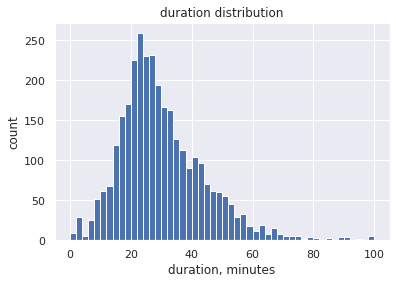

In [13]:
times.hist(bins = 50, range = (0, 100))
plt.title('duration distribution')
plt.xlabel('duration, minutes')
plt.ylabel('count')

In [14]:
times.describe()

count    3214.000000
mean       31.642294
std        21.085088
min         0.950000
25%        21.004167
50%        27.683333
75%        38.095833
max       391.416667
dtype: float64

<a id='2.2'></a>
### Схема обработки стали для первой партии

In [15]:
for df in data:
    df[df.index == 1]

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52


,Газ 1
key,
1,29.749986


,Время замера,Температура
key,,
1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:25:53,1604.0
1,2019-05-03 11:29:11,1618.0
1,2019-05-03 11:30:01,1601.0
1,2019-05-03 11:30:39,1613.0


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<a id='3'></a>
## Предварительные выводы

На обработку одной партии уходит в среднем около получаса, в каждую партию добавляют модифицирующие компоненты, при этом переодически включаются нагревательные электроды и измеряется температура расплава а ходе процесса. 

Заказчику необходимо предсказать температуру расплава для оптимизации электрозатрат. Предлагаю следующий план проекта.

## План работы

1) __Очистка данных от аномалий.__ Как показал предварительный анализ некоторые партии обрабатывались менее 1 минуты, скорее всего в данных есть ошибка и такие партии при построении модели должны быть удалены из выборки


2) __Подготовка признаков__. Очевидно темература расплава зависит от мощности подаваемой на стержни, времени нагрева, наличия добавок и начальной температуры, поэтому модель должна соответствовать функциональной зависимости 

$T_{final} = f(T_{initial}, C_{supplements}, P_{rods}, \Delta t)$

Предлагаю составить следуюзий вектор признаков $ \overline{x} = \overline{x}(T_{initial}, \overline{W}, \overline{B},V_{gas} , t_{rw}, t_{rs}, P_r)$
, где $T_{initial}$ - начальная температура, 

$\overline{W}$, $\overline{B}$ добавки сыпучих компонет и проволок, 

$t_{rw}$ - время работы электродов, $t_{rs}$ - время простоя электродов, 

$P_r $- средняя мощность стержней. 

Каждый вектор ставится в соответствие обработке одной партии, при этом время введения добавок предлагаю не учитывать. Из термодинамических соображений следует, что финальная температура зависит от конечного состояния системы, при этом путь к конечному состоянию значения не имеет.

3) __Подбор модели__ построить модель c максимальной точностью. Предлагаю попробовать следующие: линейная регрессия, случайный лес, градиентный бустинг, ff нейросеть. Предварительно на линейной регресии оценить значимость признаков.


<a id='4'></a>
## Агрегация данных

Уберем пропуски из данных с измерением температуры

In [16]:
df_temp.dropna(inplace = True)

In [17]:
df_temp.isnull().sum()

Время замера    0
Температура     0
dtype: int64

Для __партии 2__ попробуем создать признаки из данных о температуре и мощности стержней. 

In [18]:
temp_df = df_arc[df_arc.index == 2]
temp_df

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874


In [19]:
df_temp[df_temp.index == 2]

,Время замера,Температура
key,,
2,2019-05-03 11:37:27,1581.0
2,2019-05-03 11:38:00,1577.0
2,2019-05-03 11:49:38,1589.0
2,2019-05-03 11:55:50,1604.0
2,2019-05-03 11:58:24,1608.0
2,2019-05-03 11:59:12,1602.0


Найдем время первого замера температуры __t_i__  и время последнего замера __t_f__

In [20]:
t_i = df_temp[df_temp.index == 2]['Время замера'].min()
t_i

Timestamp('2019-05-03 11:37:27')

In [21]:
t_f = df_temp[df_temp.index == 2]['Время замера'].max()
t_f

Timestamp('2019-05-03 11:59:12')

Оставим данные о мощности стержней только для временного промежутка (__t_i__, __t_f__)

In [22]:
temp_df = temp_df[temp_df['Начало нагрева дугой'] >= t_i]
temp_df = temp_df[temp_df['Конец нагрева дугой'] <= t_f]
temp_df

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874


Вычислим время работы стержней на каждом включении, а так же высислим произведение мощности стержней на время работы, назовем последние величины активной и реактивной работой

In [23]:
temp_df['Время работы'] = (temp_df['Конец нагрева дугой'] - temp_df['Начало нагрева дугой']).apply(lambda t: t.total_seconds()/60)
temp_df

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время работы
key,,,,,
2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,5.633333
2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,2.100000
2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,3.500000


In [24]:
temp_df['Активная работа'] = temp_df['Активная мощность'] * temp_df['Время работы'] 
temp_df['Реактивная работа'] = temp_df['Реактивная мощность'] * temp_df['Время работы']
temp_df

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время работы,Активная работа,Реактивная работа
key,,,,,,,
2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,5.633333,7.303138,5.030080
2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,2.100000,1.029791,0.641090
2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,3.500000,2.897101,1.809058


поделив суммарное время на суммарную работу получим среднюю мощность стержней: __average_ap__ и __average_rp__

In [25]:
average_ap = temp_df['Активная работа'].sum() / temp_df['Время работы'].sum() 
average_ap

0.9997059234287833

In [26]:
average_rp = temp_df['Реактивная работа'].sum() / temp_df['Время работы'].sum() 
average_rp

0.6658957526988131

посчитаем отдельно суммарное время нагрева __time_rw__

In [27]:
time_rw = temp_df['Время работы'].sum() 
time_rw

11.233333333333334

и время в течение которого стержни были выключены __time_rs__. Это время очевидно важно - ему пропорционален уход тепла из расплава в окружающую среду

In [28]:
time_rs = (t_f - t_i ).total_seconds()/60 - time_rw
time_rs

10.516666666666666

In [29]:
initial_temp = df_temp[(df_temp['Время замера'] == t_i) & (df_temp.index == 2)]['Температура'].values[0]
initial_temp

1581.0

In [30]:
keys = set(df_arc.index.unique()).intersection(set(df_temp.index.unique()))

In [31]:
len(keys)

3214

Теперь соберем новый датафрейм, вычислив предложенные признаки для каждой партии. При этом партии в которых время замера начальной и конечной температуры одинаковы по понятным причинам выкинем

In [32]:
d = {'key' : [], 'initial_temp' : [], 'average_ap': [], 'average_rp': [], 'time_rw': [], 'time_rs': [], 'final_temp': []}
for key in keys:
    temp_df = df_arc[df_arc.index == key]
    
    t_i = df_temp[df_temp.index == key]['Время замера'].min()
    t_f = df_temp[df_temp.index == key]['Время замера'].max()
    
    if t_i == t_f:
        continue
    
    temp_df = temp_df[temp_df['Начало нагрева дугой'] >= t_i]
    temp_df = temp_df[temp_df['Конец нагрева дугой'] <= t_f]
    
    temp_df['Время работы'] = (temp_df['Конец нагрева дугой'] - temp_df['Начало нагрева дугой']).apply(lambda t: t.total_seconds()/60)
  
    
    temp_df['Активная работа'] = temp_df['Активная мощность'] * temp_df['Время работы'] 
    temp_df['Реактивная работа'] = temp_df['Реактивная мощность'] * temp_df['Время работы']
    
    d['key'].append(key)
    
    initial_temp = df_temp[(df_temp['Время замера'] == t_i) & (df_temp.index == key)]['Температура'].values[0]
    d['initial_temp'].append(initial_temp)
    
    try:
    
        average_ap = temp_df['Активная работа'].sum() / temp_df['Время работы'].sum() 
        d['average_ap'].append(average_ap)
    
        average_rp = temp_df['Реактивная работа'].sum() / temp_df['Время работы'].sum()
        d['average_rp'].append(average_rp)
        
        time_rw = temp_df['Время работы'].sum() 
        d['time_rw'].append(time_rw)
    
        time_rs = (t_f - t_i ).total_seconds()/60 - time_rw
        d['time_rs'].append(time_rs)
    
    except:
        
        d['average_ap'].append(None)
        d['average_rp'].append(None)
        d['time_rw'].append(None)
        d['time_rs'].append(None)
    
    final_temp = df_temp[(df_temp['Время замера'] == t_f) & (df_temp.index == key)]['Температура'].values[0]
    d['final_temp'].append(final_temp)

Получили такой набор признаков

In [33]:
df_new_arc = pd.DataFrame(d)
df_new_arc.head()

,key,initial_temp,average_ap,average_rp,time_rw,time_rs,final_temp
0,1,1571.0,1.380497,0.875644,8.550000,5.800000,1613.0
1,2,1581.0,0.999706,0.665896,11.233333,10.516667,1602.0
2,3,1596.0,0.389889,0.247783,6.250000,15.416667,1599.0
3,4,1601.0,1.220955,0.754719,4.633333,1.833333,1625.0
4,5,1576.0,1.423828,0.921293,8.100000,4.600000,1602.0


In [34]:
len(df_new_arc)

2475

In [35]:
df_new_arc.dropna(inplace = True)
df_new_arc.set_index('key', inplace = True)

In [36]:
df_new_arc

,initial_temp,average_ap,average_rp,time_rw,time_rs,final_temp
key,,,,,,
1,1571.0,1.380497,0.875644,8.550000,5.800000,1613.0
2,1581.0,0.999706,0.665896,11.233333,10.516667,1602.0
3,1596.0,0.389889,0.247783,6.250000,15.416667,1599.0
4,1601.0,1.220955,0.754719,4.633333,1.833333,1625.0
5,1576.0,1.423828,0.921293,8.100000,4.600000,1602.0
...,...,...,...,...,...,...
2495,1570.0,0.862477,0.613526,8.600000,10.350000,1591.0
2496,1554.0,0.828449,0.549479,13.716667,13.250000,1591.0
2497,1571.0,0.815744,0.673446,6.883333,5.066667,1589.0


Добавим данные о сыпучих материалах, проволках и продуве газом

In [37]:
df_gas.columns = ['gas']
df = df_new_arc.join(how = 'left', other = [df_bulk.fillna(0), df_gas.fillna(0), df_wire.fillna(0)])
df

,initial_temp,average_ap,average_rp,time_rw,time_rs,final_temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1.380497,0.875644,8.550000,5.800000,1613.0,0.0,0.0,0.0,43.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,0.999706,0.665896,11.233333,10.516667,1602.0,0.0,0.0,0.0,73.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,0.389889,0.247783,6.250000,15.416667,1599.0,0.0,0.0,0.0,34.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1.220955,0.754719,4.633333,1.833333,1625.0,0.0,0.0,0.0,81.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1.423828,0.921293,8.100000,4.600000,1602.0,0.0,0.0,0.0,78.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,0.862477,0.613526,8.600000,10.350000,1591.0,0.0,0.0,21.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,1554.0,0.828449,0.549479,13.716667,13.250000,1591.0,0.0,0.0,0.0,63.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,1571.0,0.815744,0.673446,6.883333,5.066667,1589.0,0.0,0.0,0.0,85.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Пропуски в добавках заполним нулями

In [38]:
df = df.fillna(0)

Удалим бесконечности возникшие из-за промежутков между __t_i__ и __t_f__

In [39]:
df.replace([np.inf, -np.inf], None, inplace=True)

initial_temp    None
average_ap      None
average_rp      None
time_rw         None
time_rs         None
final_temp      None
Bulk 1          None
Bulk 2          None
Bulk 3          None
Bulk 4          None
Bulk 5          None
Bulk 6          None
Bulk 7          None
Bulk 8          None
Bulk 9          None
Bulk 10         None
Bulk 11         None
Bulk 12         None
Bulk 13         None
Bulk 14         None
Bulk 15         None
gas             None
Wire 1          None
Wire 2          None
Wire 3          None
Wire 4          None
Wire 5          None
Wire 6          None
Wire 7          None
Wire 8          None
Wire 9          None
dtype: object

In [40]:
df.isna().sum().sum()

0

Теперь отчистим данные от аномальных значений

<a id='5'></a>
## Работа с аномалиями

<AxesSubplot:>

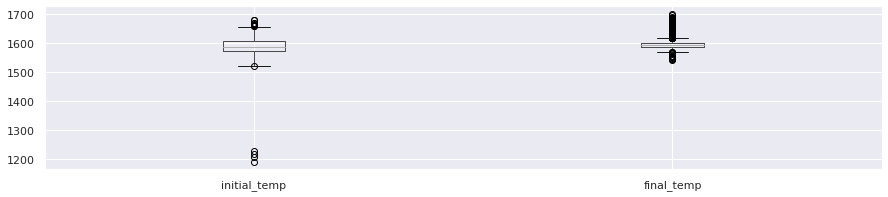

In [41]:
fig = plt.figure(figsize=(15,3))
df[['initial_temp', 'final_temp']].boxplot()

In [42]:
df = df.query('initial_temp > 1300')
df = df.query('final_temp < 1700')

<AxesSubplot:>

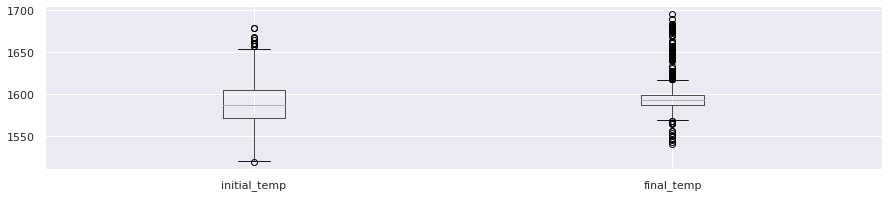

In [43]:
fig = plt.figure(figsize=(15,3))
df[['initial_temp', 'final_temp']].boxplot()

<AxesSubplot:>

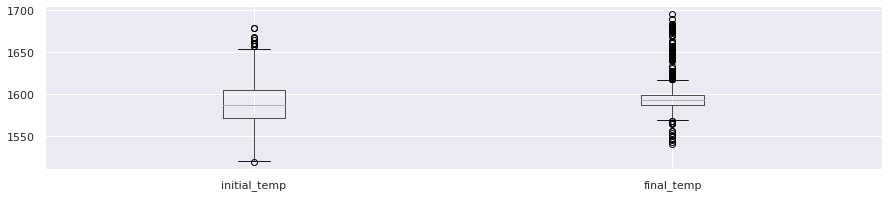

In [44]:
fig = plt.figure(figsize=(15,3))
df[['initial_temp', 'final_temp']].boxplot()

<AxesSubplot:>

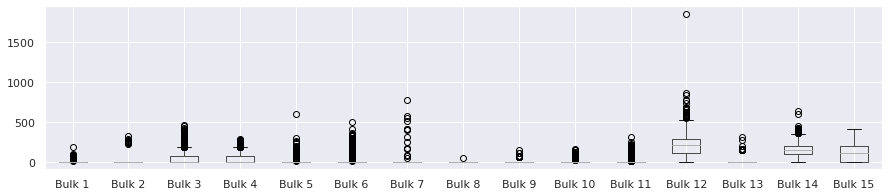

In [45]:
fig = plt.figure(figsize=(15,3))
df[df_bulk.columns].boxplot()

In [46]:
df = df[df['Bulk 12'] < 1000]

<AxesSubplot:>

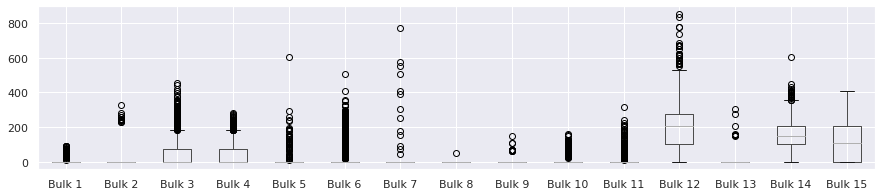

In [47]:
fig = plt.figure(figsize=(15,3))
df[df_bulk.columns].boxplot()

<AxesSubplot:>

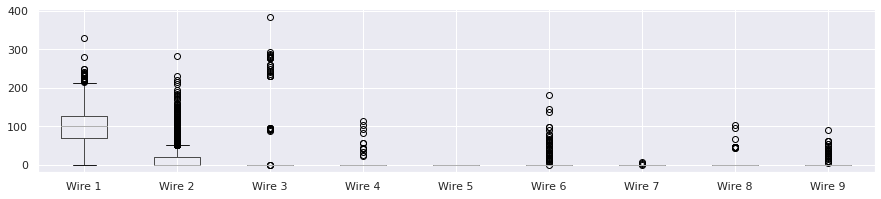

In [48]:
fig = plt.figure(figsize=(15,3))
df[df_wire.columns].boxplot()

<AxesSubplot:>

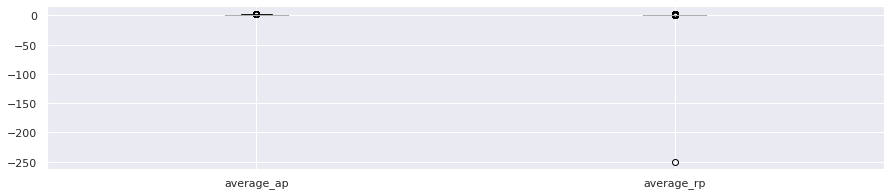

In [49]:
fig = plt.figure(figsize=(15,3))
df[['average_ap', 'average_rp']].boxplot()

In [50]:
df = df.query('average_rp > 0')

<AxesSubplot:>

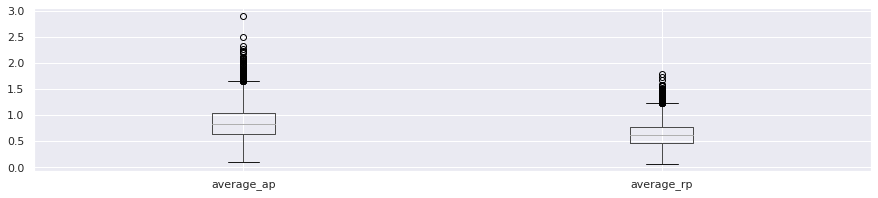

In [51]:
fig = plt.figure(figsize=(15,3))
df[['average_ap', 'average_rp']].boxplot()

<AxesSubplot:>

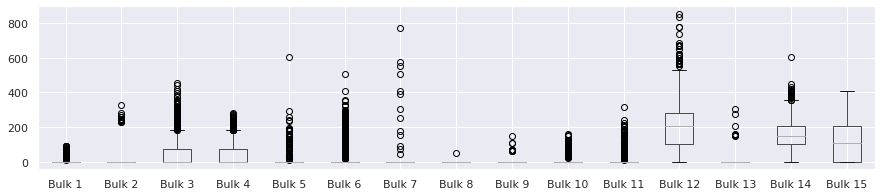

In [52]:
fig = plt.figure(figsize=(15,3))
df[df_bulk.columns].boxplot()

In [53]:
df[df_bulk.columns].describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.00000,2434.000000,2434.000000,2434.000000
mean,3.192687,1.361134,45.143796,35.382498,2.526294,21.271159,1.770748,0.020131,0.425637,4.797453,3.998357,205.32539,1.021364,151.193919,115.266639
std,11.579931,18.668056,74.254734,57.832677,21.920126,54.324833,28.884040,0.993198,6.085601,20.412788,21.938898,153.79013,13.926188,82.994081,86.166563
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.00000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.00000,0.000000,149.000000,106.000000
75%,0.000000,0.000000,74.000000,72.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,278.50000,0.000000,204.000000,204.000000
max,94.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,853.00000,305.000000,601.000000,405.000000


<AxesSubplot:>

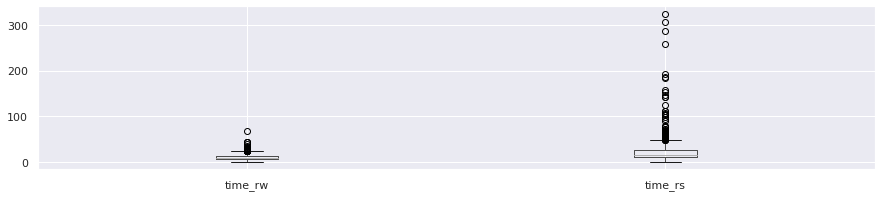

In [54]:
fig = plt.figure(figsize=(15,3))
df[['time_rw', 'time_rs']].boxplot()

In [55]:
df.shape

(2434, 31)

<a id='6'></a>
## Подготовка данных к обучению

In [56]:
features = df.drop('final_temp', axis = 1)
features.head()

,initial_temp,average_ap,average_rp,time_rw,time_rs,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1.380497,0.875644,8.550000,5.800000,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,0.999706,0.665896,11.233333,10.516667,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,0.389889,0.247783,6.250000,15.416667,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1.220955,0.754719,4.633333,1.833333,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1.423828,0.921293,8.100000,4.600000,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
target = df['final_temp']

In [58]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 12345)

In [59]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(1947, 30) (487, 30) (1947,) (487,)


<a id='7'></a>
## Линейная регрессия

In [60]:
model = LinearRegression()

In [61]:
model.fit(features_train, target_train)

LinearRegression()

In [62]:
predicted_test = model.predict(features_test)

In [63]:
print('r2 линейной регрессии на тестовой выборке', r2_score(target_test, predicted_test))
print('mae' , mean_absolute_error(target_test, predicted_test))

r2 линейной регрессии на тестовой выборке 0.6939498386010649
mae 6.745480390861809


In [64]:
res_1 = [r2_score(target_test, predicted_test), mean_absolute_error(target_test, predicted_test)]

<a id='8'></a>
## Исследование значимости признаков c помощью линейной регрессии

Последовательно выкинем каждый признак, посмотрим как поменяются метрики линейной регрессии

In [65]:
d = {'metrics' : ['MAE', 'R2']}
for drop_col in df.drop('final_temp', axis = 1).columns:
    model = LinearRegression()
    model.fit(features_train.drop(drop_col, axis = 1), target_train)
    predicted_test = model.predict(features_test.drop(drop_col, axis = 1))
    d[drop_col] = []
    d[drop_col].append(mean_absolute_error(target_test, predicted_test))
    d[drop_col].append(r2_score(target_test, predicted_test))

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

In [66]:
result = pd.DataFrame(d)
result.set_index('metrics', inplace = True)

In [67]:
result.drop(['Bulk ' + str(i) for i in range (1, 16)] + ['Wire ' + str(i) for i in range (1, 10)], axis = 1)

,initial_temp,average_ap,average_rp,time_rw,time_rs,gas
metrics,,,,,,
MAE,9.538366,7.542253,7.093772,7.406966,7.269375,6.728510
R2,0.261781,0.614291,0.658166,0.599784,0.634660,0.695562


In [68]:
result[['Bulk ' + str(i) for i in range (1, 16)]]

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
metrics,,,,,,,,,,,,,,,
MAE,6.833969,6.745729,6.757783,6.754304,6.742834,6.766976,6.741471,6.745920,6.745184,6.750126,6.734243,6.752065,6.740551,6.868958,6.743096
R2,0.684569,0.693913,0.692527,0.692829,0.694131,0.691387,0.693797,0.693754,0.693820,0.693380,0.694908,0.693605,0.694546,0.687258,0.693039


In [69]:
result[['Wire ' + str(i) for i in range (1, 10)]]

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
metrics,,,,,,,,,
MAE,6.743003,6.880592,6.748606,6.741289,6.74548,6.741620,6.744542,6.744969,6.747450
R2,0.693298,0.683590,0.693875,0.694092,0.69395,0.696283,0.693668,0.693867,0.693936


Наиболее значимые добавки __BULK - 1, 14__ и __WIRE 2__

<a id='9'></a>
## Случайный лес

In [70]:
def cv_table(CV_model):
    
    d = {}
    for param in CV_model.cv_results_['params'][0].keys():
        d[param] = []
    
    for string in CV_model.cv_results_['params']:
            for param in CV_model.cv_results_['params'][0].keys():
                d[param].append(string[param])
    
    d['R2'] = list(CV_model.cv_results_['mean_test_score'])
    return pd.DataFrame(d)

In [71]:
param_grid = { 
    'n_estimators': [10, 50, 100, 500],
    'max_depth' : [5, 10, 15, 20, 25, 30],
}

In [72]:
model = RandomForestRegressor(random_state = 12345)

In [73]:
%%time
CV_rf = GridSearchCV(estimator=model, param_grid=param_grid, cv= 3)
CV_rf.fit(features_train, target_train)

CPU times: user 1min 24s, sys: 0 ns, total: 1min 24s
Wall time: 1min 24s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30],
                         'n_estimators': [10, 50, 100, 500]})

<AxesSubplot:xlabel='max_depth', ylabel='R2'>

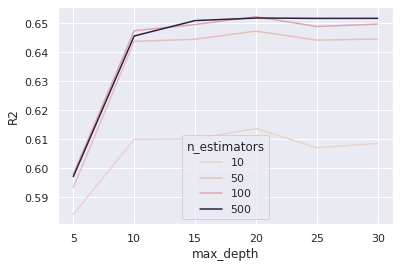

In [74]:
sns.lineplot(data = cv_table(CV_rf), x = 'max_depth', y = 'R2', hue = 'n_estimators')

In [75]:
CV_rf.best_params_

{'max_depth': 20, 'n_estimators': 100}

In [76]:
model = RandomForestRegressor(max_depth = 20, n_estimators = 100, random_state = 12345)

In [77]:
model.fit(features_train, target_train)

RandomForestRegressor(max_depth=20, random_state=12345)

In [78]:
predicted_test = model.predict(features_test)

In [79]:
print('r2 случайного леса на тестовой выборке', r2_score(target_test, predicted_test))
print('mae' , mean_absolute_error(target_test, predicted_test))
print('оптимальные параметры' , CV_rf.best_params_)

r2 случайного леса на тестовой выборке 0.7392408326000314
mae 5.894765610880836
оптимальные параметры {'max_depth': 20, 'n_estimators': 100}


In [80]:
res2 = [r2_score(target_test, predicted_test), mean_absolute_error(target_test, predicted_test)]

<a id='10'></a>
## Исследование значимости признаков с помощью случайного леса

<AxesSubplot:>

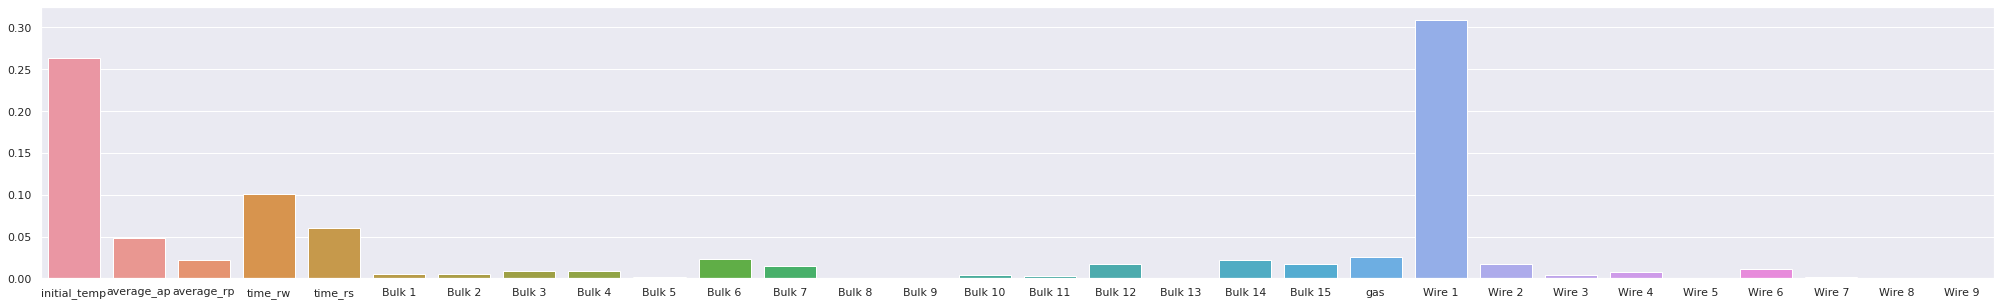

In [81]:
fig = plt.figure(figsize=(35,5))
sns.barplot(x = features_train.columns, y = model.feature_importances_)

In [82]:
np.sort(model.feature_importances_)

array([0.00000000e+00, 3.45293198e-08, 6.21904959e-05, 6.70952061e-05,
       1.03255904e-04, 1.41892875e-04, 1.17308935e-03, 1.32578549e-03,
       2.92636504e-03, 3.46270378e-03, 4.30066246e-03, 5.13084874e-03,
       5.18542173e-03, 7.35101863e-03, 8.45451633e-03, 9.29840497e-03,
       1.10674342e-02, 1.43284331e-02, 1.67536112e-02, 1.70523009e-02,
       1.75242537e-02, 2.15554275e-02, 2.20552970e-02, 2.35703649e-02,
       2.59490165e-02, 4.80737964e-02, 5.99337982e-02, 1.00529941e-01,
       2.63447714e-01, 3.09175326e-01])

Оставим признаки со знаимостью более 10E-4

In [83]:
df_imp = pd.DataFrame(data = [model.feature_importances_], columns = features_train.columns).T

список наименее значимых признаков

In [84]:
df_imp[df_imp[0] < 10E-4]

,0
Bulk 8,3.452932e-08
Bulk 9,6.219050e-05
Bulk 13,6.709521e-05
Wire 5,0.000000e+00
Wire 8,1.418929e-04
Wire 9,1.032559e-04


In [85]:
unimp_col = df_imp[df_imp[0] < 10E-4].T.columns
unimp_col

Index(['Bulk 8', 'Bulk 9', 'Bulk 13', 'Wire 5', 'Wire 8', 'Wire 9'], dtype='object')

<a id='11'></a>
## LightGBM

In [86]:
model = LGBMRegressor(random_state = 12345)

Согласно документации количество листьев недолжно превышать $2^{depth} = 512$ при depth = 9, учтем это при подборе гиперпараметров

In [87]:
param_grid = { 
    'n_estimators': [500],
    'max_depth' : [1, 2, 3, 4, 5, 7, 9],
    'num_leaves' : [5, 10, 50]
}

In [88]:
%%time
CV_gb = GridSearchCV(estimator=model, param_grid=param_grid, cv= 3)
CV_gb.fit(features_train, target_train)

CPU times: user 45.5 s, sys: 0 ns, total: 45.5 s
Wall time: 5.74 s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 7, 9],
                         'n_estimators': [500], 'num_leaves': [5, 10, 50]})

In [89]:
CV_gb.best_params_

{'max_depth': 4, 'n_estimators': 500, 'num_leaves': 5}

<AxesSubplot:xlabel='max_depth', ylabel='R2'>

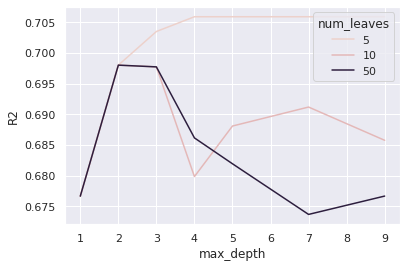

In [90]:
sns.lineplot(data = cv_table(CV_gb), x = 'max_depth', y = 'R2', hue = 'num_leaves')

In [91]:
model = LGBMRegressor(max_depth = 4, n_estimators = 500,  num_leaves = 5, random_state = 12345)

In [92]:
model.fit(features_train, target_train)

LGBMRegressor(max_depth=4, n_estimators=500, num_leaves=5, random_state=12345)

In [93]:
predicted_test = model.predict(features_test)

In [94]:
print('r2 градиентного бустинга на тестовой выборке', r2_score(target_test, predicted_test))
print('mae' , mean_absolute_error(target_test, predicted_test))
print('оптимальные параметры' , CV_gb.best_params_)

r2 градиентного бустинга на тестовой выборке 0.7677822808363184
mae 5.5076095940219885
оптимальные параметры {'max_depth': 4, 'n_estimators': 500, 'num_leaves': 5}


In [95]:
res3 = [r2_score(target_test, predicted_test), mean_absolute_error(target_test, predicted_test)]

In [103]:
def _color_red_or_green(val):
    color = 'red' if val == True else 'green'
    return 'color: %s' % color

In [104]:
((df[['Bulk ' + str(i) for i in range (1, 16)]].corr() > 0.8)
                                               .style.applymap(_color_red_or_green))

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
Bulk 1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
Bulk 5,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
Bulk 6,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
Bulk 7,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
Bulk 8,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
Bulk 9,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
Bulk 10,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [105]:
((df[['Wire ' + str(i) for i in range (1, 10)]].corr() > 0.8)
                                               .style.applymap(_color_red_or_green))

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Wire 1,True,False,False,False,False,False,False,False,False
Wire 2,False,True,False,False,False,False,False,False,False
Wire 3,False,False,True,False,False,False,False,False,False
Wire 4,False,False,False,True,False,False,False,False,False
Wire 5,False,False,False,False,False,False,False,False,False
Wire 6,False,False,False,False,False,True,False,False,False
Wire 7,False,False,False,False,False,False,True,False,False
Wire 8,False,False,False,False,False,False,False,True,False
Wire 9,False,False,False,False,False,False,False,False,True


In [106]:
df[['average_rp', 'average_ap']].corr()

,average_rp,average_ap
average_rp,1.000000,0.942967
average_ap,0.942967,1.000000


активная и реактивная мощность почти линейно связаны, одну из них можно убрать из обучающей выборки

<AxesSubplot:xlabel='average_rp', ylabel='average_ap'>

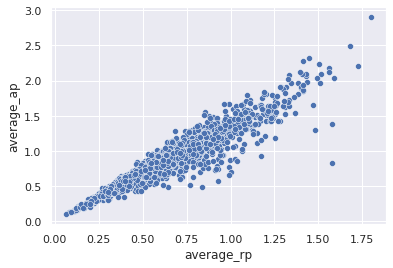

In [107]:
sns.scatterplot(data = df, x = 'average_rp', y = 'average_ap')

<a id='12'></a>
## Обучение модели-лидера на значимых призаках

In [108]:
features = df.drop(['final_temp'] + list(unimp_col) + ['average_rp'], axis = 1)
features.head()

,initial_temp,average_ap,time_rw,time_rs,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 12,Bulk 14,Bulk 15,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1.380497,8.550000,5.800000,0.0,0.0,0.0,43.0,0.0,0.0,...,206.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0
2,1581.0,0.999706,11.233333,10.516667,0.0,0.0,0.0,73.0,0.0,0.0,...,206.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0
3,1596.0,0.389889,6.250000,15.416667,0.0,0.0,0.0,34.0,0.0,0.0,...,205.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0
4,1601.0,1.220955,4.633333,1.833333,0.0,0.0,0.0,81.0,0.0,0.0,...,207.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0
5,1576.0,1.423828,8.100000,4.600000,0.0,0.0,0.0,78.0,0.0,0.0,...,203.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0


In [109]:
target = df['final_temp']

In [110]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 12345)

In [111]:
model = LGBMRegressor(max_depth = 4, n_estimators = 500,  num_leaves = 5, random_state = 12345)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print(r2_score(target_test, predicted_test), mean_absolute_error(target_test, predicted_test))

LGBMRegressor(max_depth=4, n_estimators=500, num_leaves=5, random_state=12345)

0.764221692529274 5.594778291202059


Качество немного снизилось

<a id='13'></a>
## Общий вывод

In [112]:
final = pd.DataFrame(data = [['Линейная регрессия'] + res_1, ['Случайный лес'] + res2, ['LightGBM'] + res3] )
final.columns = ['модель', 'R2', 'MAE']
final

,модель,R2,MAE
0,Линейная регрессия,0.693950,6.745480
1,Случайный лес,0.739241,5.894766
2,LightGBM,0.767782,5.507610


Ожидаемо наилучший результат получили на бустинге - МАЕ = 5.5 градуса, случайный лес дал похожие результаты, но немного хуже и время обучения оказалось значительно выше - поэтому выбор модели одназначен - LightGBM. На нейросетях ничего осмысленного не получилось - даже воспроизвести результат линейной регрессии на одном нейроне. Возможно мало данных и методы оптимизации вшитые в keras дают такой абсурд.

## Отчет по решению

1) Из исходных данных сформирировали признаки

* __initial_temp__ - начальная температура

* $t_{rw}$ - время работы электродов, $t_{rs}$ - время простоя электродов,

* __average_rp__, __average_ap__ - средняя реактивная и активная мощность нагревающих стержней

* $Bulk_{i}$, $Wire_{i}$ - обьемы супучих и проволочных добавок

* __Gas__ - обьем продуваемого газа

Целевой признак - финальная температура - __final_temp__

3) На этапе предобработки были удалены партии с совпадающими временами начального и конечного замера температуры, партии с аномальными значениями мощности (отрицательные значения договорились считать ошибками) а так же с начальными температурами меньшими тепературами плавления стали 

2) Построили несколько моделей: линейная регрессия, случайный лес, градиентный бустинг.


3) Наилучший результат достигнут на LightGBM (500 деревьев, максимальная глубина 4, количество листьев 5) - __MAE = 5.5 градусов__


4) Анализ значимости признаков показал, что __Bulk 8__, __Bulk 9__, __Bulk 13__ и __Wire 5__, __Wire 8__, __Wire 9__ не значимы, а реактивные и активные мощности сильно коррелированы  (corr = 0.94). После удаления незначимых добавок и реактивной мощности качество LightGBM незначительно ухудшилось - __MAE = 5.6 градусов__